In [80]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

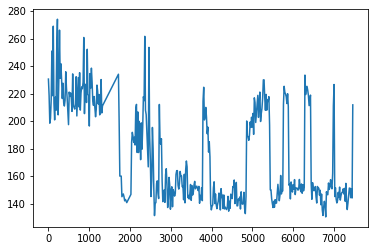

In [81]:
training_set = pd.read_csv('/content/feeds.csv')

#training_set = training_set.iloc[:,1:2].values

#plt.plot(training_set, label = 'Shampoo Sales Data')
plt.plot(training_set['Time'],training_set['Watt'] ,label = 'Energy')
plt.show()

In [82]:
pd.read_csv('/content/feeds.csv')

,Time,Watt
0,0,230.56792
1,17,218.54192
2,34,198.47443
3,51,201.97946
4,68,215.42940
...,...,...
435,7395,151.18636
436,7412,144.28439
437,7429,150.76614
438,7446,144.04976


In [83]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [84]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [85]:
num_epochs = 10000
learning_rate = 0.03

input_size = 2
hidden_size = 15
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
#t=trainX*1.01
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX*1.02)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    outputs=nn.Dropout(.5)
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([291, 2])) that is different to the input size (torch.Size([291, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, loss: 0.09011
Epoch: 100, loss: 0.04603
Epoch: 200, loss: 0.04590
Epoch: 300, loss: 0.04581
Epoch: 400, loss: 0.04632
Epoch: 500, loss: 0.04560
Epoch: 600, loss: 0.04549
Epoch: 700, loss: 0.04541
Epoch: 800, loss: 0.04536
Epoch: 900, loss: 0.04543
Epoch: 1000, loss: 0.04520
Epoch: 1100, loss: 0.04489
Epoch: 1200, loss: 0.04458
Epoch: 1300, loss: 0.04438
Epoch: 1400, loss: 0.04399
Epoch: 1500, loss: 0.04417
Epoch: 1600, loss: 0.04384
Epoch: 1700, loss: 0.04365
Epoch: 1800, loss: 0.04347
Epoch: 1900, loss: 0.04337
Epoch: 2000, loss: 0.04333
Epoch: 2100, loss: 0.04312
Epoch: 2200, loss: 0.04304
Epoch: 2300, loss: 0.04302
Epoch: 2400, loss: 0.04302
Epoch: 2500, loss: 0.04297
Epoch: 2600, loss: 0.04291
Epoch: 2700, loss: 0.04288
Epoch: 2800, loss: 0.04313
Epoch: 2900, loss: 0.04305
Epoch: 3000, loss: 0.04282
Epoch: 3100, loss: 0.04286
Epoch: 3200, loss: 0.04284
Epoch: 3300, loss: 0.04279
Epoch: 3400, loss: 0.04279
Epoch: 3500, loss: 0.04280
Epoch: 3600, loss: 0.04286
Epoch: 3700, 

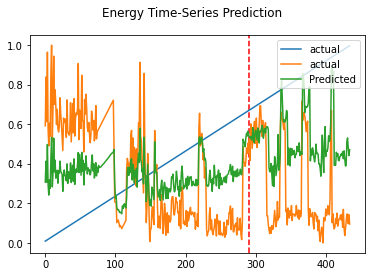

In [86]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

# data_predict = sc.inverse_transform(data_predict)
# dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot, label='actual')
plt.plot(data_predict,label='Predicted')
plt.suptitle('Energy Time-Series Prediction')
plt.legend(loc="upper right")
plt.show()

In [87]:
torch.save(lstm.state_dict(),'Energy_prediction.pt')

In [88]:
#print(lstm.state_dict())

Loading the weights


In [89]:
# input_size = 1
# hidden_size = 2
# num_layers = 1

# num_classes = 1

# l2=LSTM(num_classes, input_size, hidden_size, num_layers)
# l2.load_state_dict(torch.load('/content/Energy_prediction.pt'))
# l2

In [90]:
y=np.array(dataY_plot)

In [91]:
y=y.flatten()

In [92]:
TW=np.sum(y)
print("The total Watt usage = ",round(TW,3),"W")

The total Watt usage =  360.716 W


In [93]:
data_predict=data_predict.flatten()
TW_pred =np.sum(data_predict)
print("The total predicted Watt usage = ",round(TW_pred,3),"W")

The total predicted Watt usage =  174.541 W


In [94]:
error =-(TW-TW_pred)*100/TW 
error

-51.61242562875822

Around 3% error

In [96]:
x=float(input("Enter the per unit cost of electricity:"))
print("Your estimated bill is Rs",round(TW_pred*x,2))

Enter the per unit cost of electricity:7.31
Your estimated bill is Rs 1275.9
